Import data from GitHub


In [ ]:
!rm -rf /content/dtsa_5509_project
!rm -rf /content/cell_images
!git clone https://github.com/rat-sparebank1/dtsa_5509_project.git

Cloning into 'dtsa_5509_project'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 50 (delta 2), reused 9 (delta 1), pack-reused 36
Receiving objects: 100% (50/50), 185.17 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Unzipped imported data

In [ ]:
!unzip -q dtsa_5509_project/data/malaria/archive.zip

Import packages needed for preprocessesing

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt


Preprocess image data using Keras Utility. The utility reads the folder, import the images and resize them, at the same time, assigning labels depending on the folder the image is placed

In [ ]:
batch_size = 32
img_height = 100
img_width = 100
image_directory = "cell_images"

train_dataset = tf.keras.utils.image_dataset_from_directory(
   image_directory,
   seed=1,
   validation_split=0.2,
   shuffle=True,
   subset='training',
   image_size=(img_height, img_width),
   batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
   image_directory,
   seed=1,
   validation_split=0.2,
   shuffle=True,
   subset='validation',
   image_size=(img_height, img_width),
   batch_size=batch_size
)


Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


Create a par small datasets for further experimentation

In [ ]:
train_dataset_small = train_dataset.take(10)
test_dataset_small = test_dataset.take(2)

We check that the labels are right

In [ ]:
print(train_dataset.class_names)
print(train_dataset.element_spec)


['Parasitized', 'Uninfected']
(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Let's take a look at some of the images

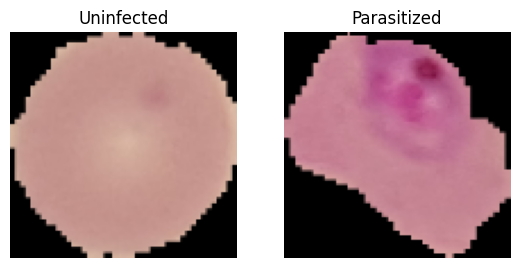

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i +1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

The train and test data is a TensorFlow dataset and before we continue we must extract the labels in a numpy array

In [ ]:

y_train = np.concatenate([y for x, y in train_dataset], axis=0)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
print(y_train[:10])
print(y_test[:10])
print(np.count_nonzero(y_train))
print(y_train.shape)
print(np.count_nonzero(y_test))
print(y_test.shape)

[0 0 1 0 0 1 0 0 0 1]
[0 1 0 0 1 1 0 0 0 0]
1614
(3200,)
386
(800,)


Do the same for the smaller datasets

In [ ]:
y_train_small = np.concatenate([y for x, y in train_dataset_small], axis=0)
y_test_small = np.concatenate([y for x, y in test_dataset_small], axis=0)
print(np.count_nonzero(y_train_small))
print(y_train_small.shape)
print(np.count_nonzero(y_test_small))
print(y_test_small.shape)

141
(320,)
27
(64,)


We can use a convolutional neural network (CNN) to preprocess our image data so we extract features from the images that in return can be used by a classifier

We define a CNN



In [ ]:


cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(100, 100, 3)))
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn.add(tf.keras.layers.Flatten())

Normalize the data so each "pixel" gets a value between 0 and 1

In [ ]:


train_ds_normalized = train_dataset.map(lambda x, y: (tf.divide(x, 255), y))
test_ds_normalized = test_dataset.map(lambda x, y: (tf.divide(x, 255), y))

train_ds_normalized_small = train_dataset_small.map(lambda x, y: (tf.divide(x, 255), y))
test_ds_normalized_small = test_dataset_small.map(lambda x, y: (tf.divide(x, 255), y))

We must train the CNN for feature extraction. The easiest way to do so, it is to define a dense layer for prediction so we can use it for metrics and backpropagation.

In [ ]:
dense_model = tf.keras.Sequential()
dense_model.add(cnn)
dense_model.add(tf.keras.layers.Dropout(0.2))
dense_model.add(tf.keras.layers.Dense(128, activation= 'relu'))
dense_model.add(tf.keras.layers.Dropout(0.2))
dense_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
dense_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

Now train the model

In [ ]:
history = dense_model.fit(train_ds_normalized, epochs=10, validation_data=test_ds_normalized)

Epoch 1/10
100/100 [==============================] - 6s 39ms/step - loss: 0.6920 - accuracy: 0.5647 - val_loss: 0.6111 - val_accuracy: 0.6862
Epoch 2/10
100/100 [==============================] - 6s 54ms/step - loss: 0.5453 - accuracy: 0.7384 - val_loss: 0.3764 - val_accuracy: 0.8788
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.3011 - accuracy: 0.9034 - val_loss: 0.2803 - val_accuracy: 0.9150
Epoch 4/10
100/100 [==============================] - 4s 37ms/step - loss: 0.2338 - accuracy: 0.9166 - val_loss: 0.2454 - val_accuracy: 0.9087
Epoch 5/10
100/100 [==============================] - 5s 48ms/step - loss: 0.1743 - accuracy: 0.9372 - val_loss: 0.2085 - val_accuracy: 0.9312
Epoch 6/10
100/100 [==============================] - 4s 38ms/step - loss: 0.1495 - accuracy: 0.9456 - val_loss: 0.2419 - val_accuracy: 0.9275
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 0.1210 - accuracy: 0.9538 - val_loss: 0.2449 - val_accuracy: 0.9225

Text(0.5, 1.0, 'Accuracy Dense Model')

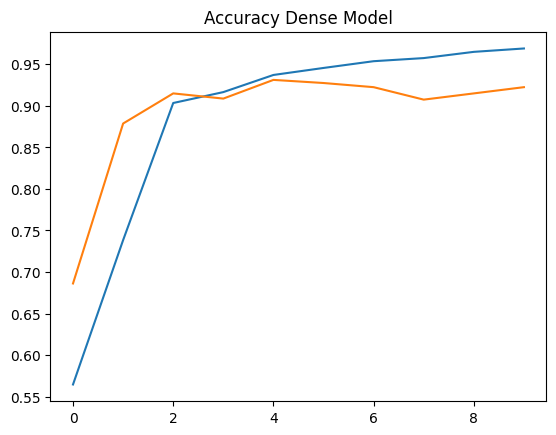

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Dense Model")

First we have to use the CNN to extract the features from the images.

In [ ]:
x_train_features = cnn.predict(train_ds_normalized)
x_test_features = cnn.predict(test_ds_normalized)

25/25 [==============================] - 1s 15ms/step


Import a Random Forest classifier and replace the dense layers with a Random Forest and compare the results

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_forest = RandomForestClassifier(n_estimators=50, random_state=42)

random_forest.fit(x_train_features, y_train)

y_train_pred = random_forest.predict(x_train_features)
y_test_pred = random_forest.predict(x_test_features)

print("model train accuracy for random forest is", metrics.accuracy_score(y_train, y_train_pred))
print("model validation accuracy for random forest is", metrics.accuracy_score(y_test, y_test_pred))



model train accuracy for random forest is 1.0
model validation accuracy for random forest is 0.48875


The model is overfitting.
I will try three thing:
1. Reduce the number of estimators
2. Use max_depth
3. Use min_samples

In [ ]:
random_forest_adjusted = RandomForestClassifier(n_estimators=25, max_depth=5, min_samples_split=4, random_state=42)

random_forest_adjusted.fit(x_train_features, y_train)

y_train_pred = random_forest_adjusted.predict(x_train_features)
y_test_pred = random_forest_adjusted.predict(x_test_features)

print("model train accuracy for random forest is", metrics.accuracy_score(y_train, y_train_pred))
print("model validation accuracy for random forest is", metrics.accuracy_score(y_test, y_test_pred))

model train accuracy for random forest is 0.7128125
model validation accuracy for random forest is 0.48625


Less overfitting but still test accuracy just marginally better than random guess. Try with Gradient boosting due to large number of features

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_features='sqrt')


gbc.fit(x_train_features, y_train)

y_train_pred = gbc.predict(x_train_features)
y_test_pred = gbc.predict(x_test_features)

print("model train accuracy for random forest is", metrics.accuracy_score(y_train, y_train_pred))
print("model validation accuracy for random forest is", metrics.accuracy_score(y_test, y_test_pred))

model train accuracy for random forest is 0.686875
model validation accuracy for random forest is 0.51375


Now try with GridSearchCV to find the best estimator using RF

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [20, 50, 100], 'max_depth': [4, 5, 6, 8], 'min_samples_split': [3, 4, 5]}

clf = GridSearchCV(estimator = RandomForestClassifier(), scoring = 'accuracy', cv=2, param_grid = params, verbose=1)
estimators = clf.fit(x_train_features, y_train)
estimators.best_estimator_



Fitting 2 folds for each of 36 candidates, totalling 72 fits


RandomForestClassifier(max_depth=8, min_samples_split=5, n_estimators=20)

In [ ]:
# Print Accuracy score
print(estimators.best_score_)

0.5171875


Now we will try the effect on the same models of having less data. Frist defined a CNN and the same dense model again

In [ ]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(100, 100, 3)))
cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn.add(tf.keras.layers.Flatten())

dense_model = tf.keras.Sequential()
dense_model.add(cnn)
dense_model.add(tf.keras.layers.Dropout(0.2))
dense_model.add(tf.keras.layers.Dense(128, activation= 'relu'))
dense_model.add(tf.keras.layers.Dropout(0.2))
dense_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
dense_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

history = dense_model.fit(train_ds_normalized_small, epochs=10, validation_data=test_ds_normalized_small)

Epoch 1/10
10/10 [==============================] - 3s 71ms/step - loss: 1.2552 - accuracy: 0.5312 - val_loss: 0.6941 - val_accuracy: 0.4688
Epoch 2/10
10/10 [==============================] - 1s 68ms/step - loss: 0.6959 - accuracy: 0.5125 - val_loss: 0.6846 - val_accuracy: 0.5625
Epoch 3/10
10/10 [==============================] - 1s 89ms/step - loss: 0.6921 - accuracy: 0.4906 - val_loss: 0.6915 - val_accuracy: 0.6406
Epoch 4/10
10/10 [==============================] - 1s 116ms/step - loss: 0.6908 - accuracy: 0.5625 - val_loss: 0.6873 - val_accuracy: 0.5156
Epoch 5/10
10/10 [==============================] - 1s 70ms/step - loss: 0.6807 - accuracy: 0.5906 - val_loss: 0.6774 - val_accuracy: 0.5938
Epoch 6/10
10/10 [==============================] - 1s 58ms/step - loss: 0.6742 - accuracy: 0.5906 - val_loss: 0.6598 - val_accuracy: 0.6875
Epoch 7/10
10/10 [==============================] - 1s 68ms/step - loss: 0.6271 - accuracy: 0.6656 - val_loss: 0.6854 - val_accuracy: 0.5469
Epoch 8/10
1

Text(0.5, 1.0, 'Accuracy Dense Model')

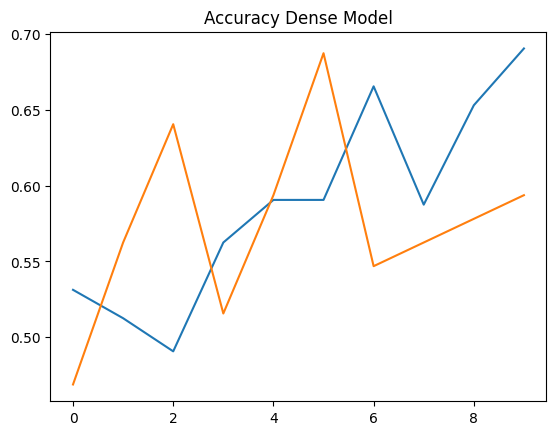

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Dense Model")

Now extract the features from the smaller datasets

In [ ]:
x_train_features_small = cnn.predict(train_ds_normalized_small)
x_test_features_small = cnn.predict(test_ds_normalized_small)

2/2 [==============================] - 0s 26ms/step


Use a Random forest to make predictions


In [ ]:
random_forest_best_estimator = RandomForestClassifier(n_estimators=20, max_depth=8, min_samples_split=5, random_state=42)

random_forest_best_estimator.fit(x_train_features_small, y_train_small)

y_train_pred_small = random_forest_best_estimator.predict(x_train_features_small)
y_test_pred_small = random_forest_best_estimator.predict(x_test_features_small)

print("model train accuracy for random forest is", metrics.accuracy_score(y_train_small, y_train_pred_small))
print("model validation accuracy for random forest is", metrics.accuracy_score(y_test_small, y_test_pred_small))

model train accuracy for random forest is 0.965625
model validation accuracy for random forest is 0.5625


## Conclusions:
* Random Forests have a clear tendency for overfitting and actions must be taken to avoid it
* GridSearchCV is very useful to make it easier to find the best estimator by tuning hyperparameters
* If little data is available (if limited access to training resources in general), it may be worth trying to use a Random Forest Classifier
* With enough data for training and validation, a Dense Neural Network together with a Convolutional Network will mostly outperform a Random Forest Classifier
* Further work related to this is to try other classifier, classify without using a Convolutional Networks or use a already trained Convolutional Network by applying transferred learning

References:

https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset

https://www.tensorflow.org/tutorials/images/cnn

https://stackoverflow.com/questions/66162684/how-to-noramilze-a-batchdataset-and-use-it-in-a-model